## Analyzing single states

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import pandas as pd
import numpy as np
import re

import glob, os
import itertools
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

from scipy.stats import gaussian_kde

import sys
sys.path.append('../local/bin/')
from sygno.nodes_position import _get_xcoord
from sygno.states_signed_networkx import draw_signed_networkx

In [19]:
dataset_folder = '../dataset/'
mmb = pd.read_csv('../dataset/HSall_members.csv')
pc = pd.read_csv('../dataset/HSall_parties.csv')

In [20]:
output_folder = '../plots/congressmen_perc_perstate/'

In [21]:
house_congress_path = '../dataset/download_votes_merged/'
senate_congress_path = '../dataset/download_votes_merged_senate/'

______________________________

In [102]:
# Thamks to https://gist.github.com/shawnbot/ab11ace1bafa23be290c193049a71cb5
state_abbrev_dic = {
  "AL": "Alabama",
  "AS": "American Samoa",
  "AK": "Alaska",
  "AZ": "Arizona",
  "AR": "Arkansas",
  "CA": "California",
  "CO": "Colorado",
  "CT": "Connecticut",
  "DE": "Delaware",
  "DC": "District of Columbia",
  "FL": "Florida",
  "GA": "Georgia",
  "GU": "Guam",
  "HI": "Hawaii",
  "ID": "Idaho",
  "IL": "Illinois",
  "IN": "Indiana",
  "IA": "Iowa",
  "KS": "Kansas",
  "KY": "Kentucky",
  "LA": "Louisiana",
  "ME": "Maine",
  "MD": "Maryland",
  "MA": "Massachusetts",
  "MI": "Michigan",
  "MN": "Minnesota",
  "MS": "Mississippi",
  "MO": "Missouri",
  "MT": "Montana",
  "MP": "Northern Mariana Islands",
  "NE": "Nebraska",
  "NV": "Nevada",
  "NH": "New Hampshire",
  "NJ": "New Jersey",
  "NM": "New Mexico",
  "NY": "New York",
  "NC": "North Carolina",
  "ND": "North Dakota",
  "OH": "Ohio",
  "OK": "Oklahoma",
  "OR": "Oregon",
  "PA": "Pennsylvania",
  "PR": "Puerto Rico",
  "RI": "Rhode Island",
  "SC": "South Carolina",
  "SD": "South Dakota",
  "TN": "Tennessee",
  "TX": "Texas",
  "UT": "Utah",
  "VI": "US Virgin Islands",
  "VT": "Vermont",
  "VA": "Virginia",
  "WA": "Washington",
  "WV": "West Virginia",
  "WI": "Wisconsin",
  "WY": "Wyoming",
  "USA": "United States of America (President of the United States)",
}

________________________________

In [111]:
def create_members_df():
    temp_congress = mmb.groupby('icpsr', as_index=False)[['congress']].agg(lambda x: list(x))
    temp_party = mmb.groupby('icpsr', as_index=False)[['party_code']].agg(lambda x: list(set(x)))
    temp_congress = temp_congress.merge(temp_party)
    temp_congress['bioname'] = temp_congress['icpsr'].map(mmb[['icpsr', 'bioname']].set_index('icpsr').to_dict()['bioname'])
    temp_congress['state_abbrev'] = temp_congress['icpsr'].map(mmb[['icpsr', 'state_abbrev']].set_index('icpsr').to_dict()['state_abbrev'])
    temp_congress['district_code'] = temp_congress['icpsr'].map(mmb[['icpsr', 'district_code']].set_index('icpsr').to_dict()['district_code'])
    party_codes_dic = pc[['party_name', 'party_code']].set_index('party_code').to_dict()['party_name']
    temp_congress['party_name'] = temp_congress['party_code'].apply(lambda x: [party_codes_dic[y] for y in x])
    return temp_congress

members = create_members_df()

members2state_dic = members.set_index('icpsr')['state_abbrev'].to_dict()
members2district_dic = members.set_index('icpsr')['district_code'].to_dict()
members_party_dict = members.set_index('icpsr')['party_name'].to_dict()

#### Retrieve a dynamics for each state

In [24]:
# Test
test_congress = pd.read_csv(house_congress_path + 'congress_087.csv')
test_congress
test_congress['state_abbrev'] = test_congress['icpsr'].map(members2state_dic)
test_congress['district_code'] = test_congress['icpsr'].map(members2district_dic)
test_congress['party_name'] = test_congress['icpsr'].map(members_party_dict)

test_congress_TEST = test_congress[test_congress['state_abbrev'] == 'OR']

In [25]:
test_congress_TEST

,bill_number,id,description,chamber,date,vote_desc,vote_result,congress,rollnumber,Peltzman,Clausen,name,party_short_name,icpsr,vote,state_abbrev,district_code,party_name
324,HR12648,RH0870227,H.R. 12648. FISCAL 1963 AGRICULTURE DEPARTMEN...,House,1962-10-04,NaN,NaN,87,227,Budget Special Interest,Agriculture,"NORBLAD, Albin Walter, Jr.",Republican,6955,Yea,OR,1.0,[Republican]
325,HR12648,RH0870227,H.R. 12648. FISCAL 1963 AGRICULTURE DEPARTMEN...,House,1962-10-04,NaN,NaN,87,227,Budget Special Interest,Agriculture,"ULLMAN, Albert Conrad",Democrat,9551,Abs,OR,2.0,[Democrat]
326,HR12648,RH0870227,H.R. 12648. FISCAL 1963 AGRICULTURE DEPARTMEN...,House,1962-10-04,NaN,NaN,87,227,Budget Special Interest,Agriculture,"GREEN, Edith Starrett",Democrat,3775,Yea,OR,3.0,[Democrat]
327,HR12648,RH0870227,H.R. 12648. FISCAL 1963 AGRICULTURE DEPARTMEN...,House,1962-10-04,NaN,NaN,87,227,Budget Special Interest,Agriculture,"DURNO, Edwin Russell",Republican,10515,Yea,OR,4.0,[Republican]
761,HR11222,RH0870161,H.R. 11222. FOOD AND AGRICULTURE ACT OF 1962....,House,1962-06-21,NaN,NaN,87,161,Regulation Special Interest,Agriculture,"NORBLAD, Albin Walter, Jr.",Republican,6955,Yea,OR,1.0,[Republican]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104043,NaN,RH0870001,ELECTION OF SPEAKER. RAYBURN VERSUS HALLECK. ...,House,1961-01-03,NaN,NaN,87,1,Internal Organization,Miscellaneous Policy,"DURNO, Edwin Russell",Republican,10515,Nay,OR,4.0,[Republican]
104477,HR8666,RH0870092,H.R. 8666. MUTUAL EDUCATION AND CULTURAL EXCH...,House,1961-09-06,NaN,NaN,87,92,Foreign Policy Budget,Foreign and Defense Policy,"NORBLAD, Albin Walter, Jr.",Republican,6955,Yea,OR,1.0,[Republican]
104478,HR8666,RH0870092,H.R. 8666. MUTUAL EDUCATION AND CULTURAL EXCH...,House,1961-09-06,NaN,NaN,87,92,Foreign Policy Budget,Foreign and Defense Policy,"ULLMAN, Albert Conrad",Democrat,9551,Yea,OR,2.0,[Democrat]
104479,HR8666,RH0870092,H.R. 8666. MUTUAL EDUCATION AND CULTURAL EXCH...,House,1961-09-06,NaN,NaN,87,92,Foreign Policy Budget,Foreign and Defense Policy,"GREEN, Edith Starrett",Democrat,3775,Yea,OR,3.0,[Democrat]


List of the states

In [113]:
a = set(members2state_dic.values())
b = set(state_abbrev_dic.keys())

# print the size of a and b
print(len(a), len(b))

print(a.difference(b))

print(b.difference(a))



57 57
set()
set()


In [26]:
states_list = list(set(members2state_dic.values()))
states_list

['HI',
 'NJ',
 'OH',
 'UT',
 'PA',
 'VT',
 'KY',
 'AS',
 'KS',
 'NY',
 'AK',
 'USA',
 'NE',
 'AZ',
 'CA',
 'OK',
 'AL',
 'IA',
 'TN',
 'IN',
 'VI',
 'CT',
 'NM',
 'LA',
 'ID',
 'GU',
 'WY',
 'DC',
 'RI',
 'GA',
 'MI',
 'SD',
 'NH',
 'OR',
 'MN',
 'AR',
 'PR',
 'DE',
 'MT',
 'NC',
 'MD',
 'FL',
 'ND',
 'WI',
 'VA',
 'IL',
 'MO',
 'MP',
 'NV',
 'SC',
 'WV',
 'WA',
 'MS',
 'TX',
 'MA',
 'ME',
 'CO']

In [27]:
cong_state_perc_list = []

for csv in tqdm(glob.glob(house_congress_path + '/*.csv')):
    curr_congress = pd.read_csv(csv)
    curr_congress['state'] = curr_congress['icpsr'].map(members2state_dic)
    curr_congress['district_code'] = curr_congress['icpsr'].map(members2district_dic)
    curr_congress['party_name'] = curr_congress['icpsr'].map(members_party_dict)

    for state in states_list:
        curr_state = curr_congress[curr_congress['state'] == state]
        total_votes = len(curr_state)

        
        if total_votes > 0:

            dem_n = 0
            rep_n = 0
            other_n = 0

            for member in curr_state['icpsr'].unique():
                # the 'party_name' column is a list of elements. We need to count the number of times each element appears in the list
                dem_n += curr_state[curr_state['icpsr'] == member]['party_name'].values[0].count('Democrat')
                rep_n += curr_state[curr_state['icpsr'] == member]['party_name'].values[0].count('Republican')
                # other in case it is not democrat or republican
                other_n += len(curr_state[curr_state['icpsr'] == member]['party_name'].values[0]) - curr_state[curr_state['icpsr'] == member]['party_name'].values[0].count('Democrat') - curr_state[curr_state['icpsr'] == member]['party_name'].values[0].count('Republican')

            tot = dem_n + rep_n + other_n

            cong_state_perc_list.append({
                'congress' : int(re.findall(r'\d+', csv)[0]),
                'state' : state,
                'total_votes' : tot,
                'total_dem' : dem_n,
                'total_rep' : rep_n,
                'total_other' : other_n,
                'perc_dem' : dem_n / tot,
                'perc_rep' : rep_n / tot,
                'perc_other' : other_n / tot
            })
        else:
            cong_state_perc_list.append({
                'congress' : int(re.findall(r'\d+', csv)[0]),
                'state' : state,
                'total_votes' : 0,
                'total_dem' : 0,
                'total_rep' : 0,
                'total_other' : 0,
                'perc_dem' : 0,
                'perc_rep' : 0,
                'perc_other' : 0
            })


cong_state_perc = pd.DataFrame(cong_state_perc_list)



  5%|▍         | 2/41 [00:05<01:52,  2.88s/it]/tmp/ipykernel_9382/1651910213.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  curr_congress = pd.read_csv(csv)
100%|██████████| 41/41 [02:19<00:00,  3.41s/it]


In [28]:
cong_state_perc

,congress,state,total_votes,total_dem,total_rep,total_other,perc_dem,perc_rep,perc_other
0,87,HI,1,1,0,0,1.000000,0.000000,0.0
1,87,NJ,14,6,8,0,0.428571,0.571429,0.0
2,87,OH,23,7,16,0,0.304348,0.695652,0.0
3,87,UT,2,2,0,0,1.000000,0.000000,0.0
4,87,PA,31,14,17,0,0.451613,0.548387,0.0
...,...,...,...,...,...,...,...,...,...
2332,84,MS,6,6,0,0,1.000000,0.000000,0.0
2333,84,TX,22,21,1,0,0.954545,0.045455,0.0
2334,84,MA,14,7,7,0,0.500000,0.500000,0.0
2335,84,ME,3,0,3,0,0.000000,1.000000,0.0


_________________________________________________________________________________________________________________________________

### Check the dynamics of polarization for a single given state

In [57]:
us_flags_dir = '../flags/mini/us/'

In [114]:
len(states_list)

57

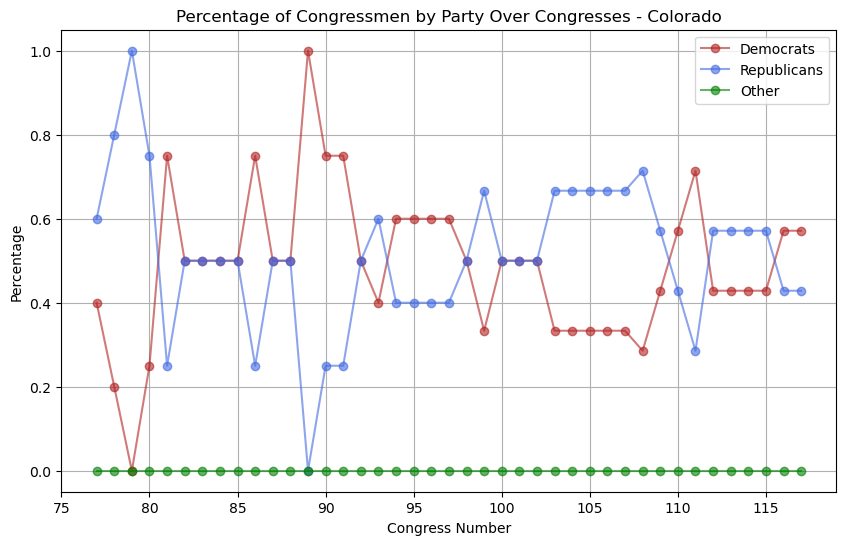

In [93]:
state = 'CO'


cong_state_perc_single_state = cong_state_perc[cong_state_perc['state'] == state]

# Sort the DataFrame by the 'congress' column
cong_state_perc_single_state = cong_state_perc_single_state.sort_values(by='congress')

# Plotting
plt.figure(figsize=(10, 6))

transparency = 0.6

plt.plot(cong_state_perc_single_state['congress'], cong_state_perc_single_state['perc_dem'], label='Democrats', marker='o', alpha=transparency, color='firebrick')
plt.plot(cong_state_perc_single_state['congress'], cong_state_perc_single_state['perc_rep'], label='Republicans', marker='o', alpha=transparency, color='royalblue')
plt.plot(cong_state_perc_single_state['congress'], cong_state_perc_single_state['perc_other'], label='Other', marker='o', alpha=transparency, color='green')

plt.title('Percentage of Congressmen by Party Over Congresses - ' + state_abbrev_dic[state])
plt.xlabel('Congress Number')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()


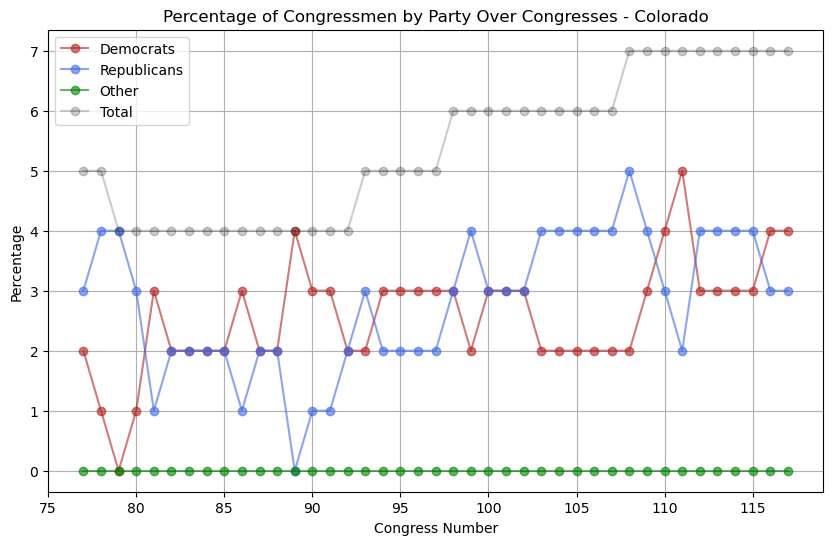

In [94]:
# Sort the DataFrame by the 'congress' column
cong_state_perc_single_state = cong_state_perc_single_state.sort_values(by='congress')

# Plotting
plt.figure(figsize=(10, 6))

transparency = 0.6
all_transparency = 0.2


plt.plot(cong_state_perc_single_state['congress'], cong_state_perc_single_state['total_dem'], label='Democrats', marker='o', alpha=transparency, color='firebrick')
plt.plot(cong_state_perc_single_state['congress'], cong_state_perc_single_state['total_rep'], label='Republicans', marker='o', alpha=transparency, color='royalblue')
plt.plot(cong_state_perc_single_state['congress'], cong_state_perc_single_state['total_other'], label='Other', marker='o', alpha=transparency, color='green')
plt.plot(cong_state_perc_single_state['congress'], cong_state_perc_single_state['total_votes'], label='Total', marker='o', alpha=all_transparency, color='black')

plt.title('Percentage of Congressmen by Party Over Congresses - ' + state_abbrev_dic[state])
plt.xlabel('Congress Number')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()

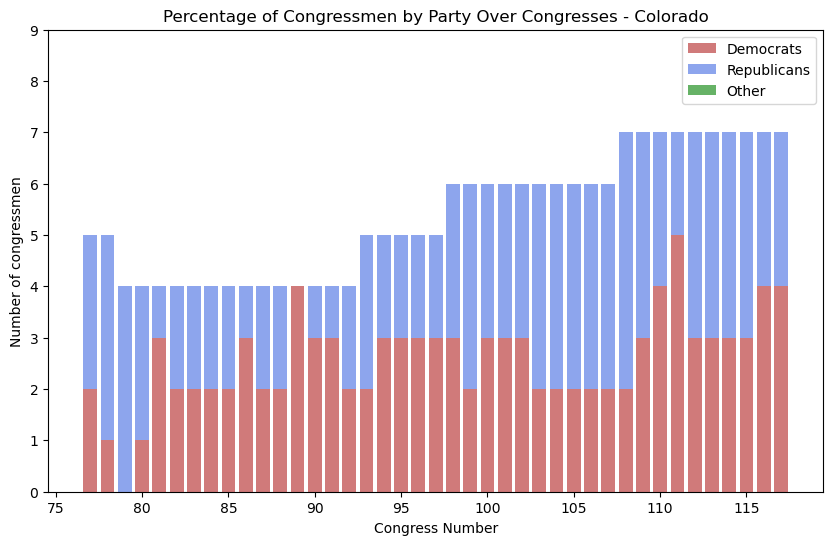

In [95]:
# Sort the DataFrame by the 'congress' column
cong_state_perc_single_state = cong_state_perc_single_state.sort_values(by='congress')

# Plotting
plt.figure(figsize=(10, 6))

transparency = 0.6

# Plotting stacked bars
plt.bar(cong_state_perc_single_state['congress'], cong_state_perc_single_state['total_dem'], label='Democrats', alpha=transparency, color='firebrick')
plt.bar(cong_state_perc_single_state['congress'], cong_state_perc_single_state['total_rep'], bottom=cong_state_perc_single_state['total_dem'], label='Republicans', alpha=transparency, color='royalblue')
plt.bar(cong_state_perc_single_state['congress'], cong_state_perc_single_state['total_other'], bottom=cong_state_perc_single_state['total_dem'] + cong_state_perc_single_state['total_rep'], label='Other', alpha=transparency, color='green')

plt.title('Percentage of Congressmen by Party Over Congresses - ' + state_abbrev_dic[state])
plt.xlabel('Congress Number')
plt.ylabel('Number of congressmen')
plt.ylim(0, max(cong_state_perc_single_state['total_votes']) + 2)
plt.legend()

plt.grid(False)

plt.show()

__________________________

Save the plots for all the different states

In [116]:
# save a plot for each state in states_list
for state in tqdm(states_list):

    if os.path.exists(output_folder + state + '.png'):
        continue

    cong_state_perc_single_state = cong_state_perc[cong_state_perc['state'] == state]
    cong_state_perc_single_state = cong_state_perc_single_state.sort_values(by='congress')

    # Plotting
    plt.figure(figsize=(10, 6))

    transparency = 0.6

    # Plotting stacked bars
    plt.bar(cong_state_perc_single_state['congress'], cong_state_perc_single_state['total_dem'], label='Democrats', alpha=transparency, color='firebrick')
    plt.bar(cong_state_perc_single_state['congress'], cong_state_perc_single_state['total_rep'], bottom=cong_state_perc_single_state['total_dem'], label='Republicans', alpha=transparency, color='royalblue')
    plt.bar(cong_state_perc_single_state['congress'], cong_state_perc_single_state['total_other'], bottom=cong_state_perc_single_state['total_dem'] + cong_state_perc_single_state['total_rep'], label='Other', alpha=transparency, color='green')

    plt.title('Percentage of Congressmen by Party Over Congresses - ' + state_abbrev_dic[state])
    plt.xlabel('Congress Number')
    plt.ylabel('Number of congressmen')
    plt.ylim(0, max(cong_state_perc_single_state['total_votes']) + 2)
    plt.legend()

    plt.grid(False)

    plt.savefig(output_folder + state + '.png', dpi=300, bbox_inches='tight')
    plt.close()

  0%|          | 0/57 [00:00<?, ?it/s]

100%|██████████| 57/57 [00:42<00:00,  1.35it/s]


______________________________________________________________________________

In [166]:
from scipy.stats import gaussian_kde

In [135]:
def compute_threshold_intersx(df, weight):	#df is the edgelist, weight is the weight of the edge

	def _midpoint(p1, p2):
		return {'x': (p1['x']+p2['x'])/2, 'y': (p1['y']+p2['y'])/2}

	def line_intersection(in_party, out_party, intersect_points):
		index_in = np.argmax(in_party[1])
		index_out = np.argmax(out_party[1])

        # points of the mean of the distributions 
		point_in={'x': in_party[0][index_in], 'y': in_party[1][index_in]}
		point_out={'x': out_party[0][index_out], 'y': out_party[1][index_out]}

        # medianpoint (mean of the means) of the two distributions
		midpoint = _midpoint(point_in, point_out)
        
        #find index of intersection closer to midpoint
		index_closer = np.argmin([np.sqrt( (p[0] - midpoint['x'])**2 + (p[1] - midpoint['y'])**2 ) for p in intersect_points])

        # return x value of closer intersection
		return intersect_points[index_closer][0]

	x0 = df.loc[(df['party']=='in')&(df['weight'] == weight)]['perc']
	x1 = df.loc[(df['party']=='out')&(df['weight'] == weight)]['perc']
    
	bw = len(x0)**(-1./(2+4))
	kde0 = gaussian_kde(x0, bw_method=bw)
	bw = len(x1)**(-1./(2+4))
	kde1 = gaussian_kde(x1, bw_method=bw)

	xmin = min(x0.min(), x1.min())
	xmax = max(x0.max(), x1.max())
	dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
	xmin -= dx
	xmax += dx

	x = np.linspace(xmin, xmax, 500)
	kde0_x = kde0(x)
	kde1_x = kde1(x)
	inters_x = np.minimum(kde0_x, kde1_x)

	idx = np.argwhere(np.diff(np.sign(kde0_x - kde1_x))).flatten()
    
	threshold = line_intersection([x, kde0_x], [x, kde0_x], [[x,y] for x,y in zip (x[idx], kde1_x[idx])])
	area_inters_x = np.trapz(inters_x, x)

	return threshold, area_inters_x

In [137]:
def plot_kde(df, weight):
    
    def _midpoint(p1, p2):
        return {'x': (p1['x']+p2['x'])/2, 'y': (p1['y']+p2['y'])/2}

    def line_intersection(in_party, out_party, intersect_points):
        index_in = np.argmax(in_party[1])
        index_out = np.argmax(out_party[1])

        # points of the mean of the distributions 
        point_in={'x': in_party[0][index_in], 'y': in_party[1][index_in]}
        point_out={'x': out_party[0][index_out], 'y': out_party[1][index_out]}

        # medianpoint (mean of the means) of the two distributions
        midpoint = _midpoint(point_in, point_out)
        
        #find index of intersection closer to midpoint
        index_closer = np.argmin([np.sqrt( (p[0] - midpoint['x'])**2 + (p[1] - midpoint['y'])**2 ) for p in intersect_points])

        # return x value of closer intersection
        return intersect_points[index_closer][0]
        
    x0 = df.loc[(df['party']=='in')&(df['weight'] == weight)]['perc']
    x1 = df.loc[(df['party']=='out')&(df['weight'] == weight)]['perc']
    
    bw = len(x0)**(-1./(2+4))
    kde0 = gaussian_kde(x0, bw_method=bw)
    bw = len(x1)**(-1./(2+4))
    kde1 = gaussian_kde(x1, bw_method=bw)

    xmin = min(x0.min(), x1.min())
    xmax = max(x0.max(), x1.max())
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx

    x = np.linspace(xmin, xmax, 500)
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    idx = np.argwhere(np.diff(np.sign(kde0_x - kde1_x))).flatten()
    
    threshold = line_intersection([x, kde0_x], [x, kde0_x], [[x,y] for x,y in zip (x[idx], kde1_x[idx])])
    
    fig1, ax1 = plt.subplots(1, 1, figsize=(17, 13))
    fig1.set_size_inches(20, 12)

    ax1.plot(x, kde0_x, color='b', label='intra-party')
    ax1.fill_between(x, kde0_x, 0, color='b', alpha=0.2)

    ax1.plot(x, kde1_x, color='orange', label='inter-party')
    ax1.fill_between(x, kde1_x, 0, color='orange', alpha=0.2)

    ax1.plot(x, inters_x, color='tomato')
    ax1.fill_between(x, inters_x, 0, facecolor='none', edgecolor='tomato', label='intersection', alpha=0.5, hatch='xx')
    
    ax1.axvspan(threshold-0.0025, threshold+0.0025,color='tomato', alpha=0.7, zorder=10)
    ax1.text(threshold-.25, .93, 'threshold: '+str(round(threshold, 2)), fontsize=23,transform=ax1.transAxes)
    
    area_inters_x = np.trapz(inters_x, x)

    handles, labels = plt.gca().get_legend_handles_labels()
    labels[2] += f': {area_inters_x * 100:.1f} %'
    ax1.tick_params(axis='both', which='major', labelsize=20)

    plt.xlabel('Edges percentage', fontsize=25)
    plt.ylabel('Density', fontsize=25)
    title = "Positive edges" if weight == 1 else "Negative edges"
    c_title = "g" if weight == 1 else "r"
    plt.title(title, fontsize=31, pad=10, ha='left', x=.0, c=c_title)

    legend1 = plt.legend([handles[0],handles[1]], [labels[0],labels[1]], loc='upper center', bbox_to_anchor=(0.4, 1.08), frameon=False, ncol=2, fontsize=23)
    plt.legend([handles[2]], [labels[2]], loc='upper center', bbox_to_anchor=(0.84, 1.08), frameon=False, ncol=1, fontsize=23)
    plt.gca().add_artist(legend1)
    plt.tight_layout()
    plt.grid(axis='y')
    
    ax1.set_xlim([-0.07, 1.1])

    plt.show()

In [155]:
def create_edgelist_from_congress(congress, members_party_dict):
	edgelist = pd.DataFrame()

	for voteid in tqdm(set(congress['id'])):                 # iterate over all votes id (ids are unique for each vote)

		temp = congress[congress['id'] == voteid]            # select the rows where the vote id is equal to the current vote id            

		yy = temp[temp['vote']=='Yea']['icpsr']              # select the icpsr of the members that voted "Yea"
		nn = temp[temp['vote']=='Nay']['icpsr']                         

		y = itertools.combinations(yy, 2)                    # all possible combinations of 2 members that voted "Yea"
		n = itertools.combinations(nn, 2)                
		o = itertools.product(yy, nn)                        # cartesian product of the 2 series

		y = pd.DataFrame(y, columns = ['source', 'target'])  # create a dataframe from the combinations of "Yea" voters
		y['weight'] = 1                                      # add a column with the weight of the edge
		y['count'] = 1                                         

		n = pd.DataFrame(n, columns = ['source', 'target'])     
		n['weight'] = 1                                         
		n['count'] = 1                                          

		o = pd.DataFrame(o, columns = ['source', 'target'])     
		o['weight'] = -1                                     # same but the link is negative                    
		o['count'] = 1                                          

		edgelist = pd.concat([edgelist, y, n, o])
		edgelist = edgelist.groupby(['source', 'target', 'weight']).sum().reset_index()     # group by source, target and weight and sum the count                  

	edgelist = pd.concat([edgelist, pd.DataFrame({
		'source': edgelist['target'],                        # new columns based on old columns: 
		'target': edgelist['source'],                        #   'newcolumn': dataframe['oldcolumn']
		'weight': edgelist['weight'],
		'count': edgelist['count']})])

	edgelist = edgelist.loc[edgelist['source'] < edgelist['target']]                    # remove duplicates
	edgelist = edgelist.groupby(['source', 'target', 'weight']).sum().reset_index()     # group by source, target and weight and sum the count
	edgelist['party'] = edgelist.apply(lambda row: 'in' if members_party_dict[row['source']] == members_party_dict[row['target']] else 'out', axis=1)   # create a column with the party of the edge

	map_votes = edgelist.groupby(['source', 'target'])['count'].sum().to_dict()                                                                         # create a dictionary with the number of votes togheter for each pair of nodes                               

	edgelist['votes_togheter'] = edgelist[['source', 'target']].apply(lambda x: map_votes[(x['source'], x['target'])], axis=1)
	edgelist['perc'] = edgelist['count']/edgelist['votes_togheter']

	return edgelist

In [209]:
# consider a test congress
test_congress = pd.read_csv(house_congress_path + 'congress_110.csv')
test_congress['state'] = test_congress['icpsr'].map(members2state_dic)
test_congress['district_code'] = test_congress['icpsr'].map(members2district_dic)
test_congress['party_name'] = test_congress['icpsr'].map(members_party_dict)

In [210]:
# extract a particuar state (TX in this case)
test_congress_TEST = test_congress[test_congress['state'] == 'CA']

In [230]:
edgelist_110 = create_edgelist_from_congress(test_congress_TEST, members_party_dict)

len(edgelist_110)

  0%|          | 0/1865 [00:00<?, ?it/s]

100%|██████████| 1865/1865 [00:29<00:00, 62.22it/s]


2947

In [231]:
thresh_pos = compute_threshold_intersx(edgelist_110, 1)[0]
thresh_neg = compute_threshold_intersx(edgelist_110, -1)[0]

print('positive threshold: ', thresh_pos)
print('negative threshold: ', thresh_neg)

positive threshold:  0.698082555643832
negative threshold:  0.29894668175460526


In [234]:
# filter the edgelist with the threshold
edgelist_110_pos = edgelist_110[(edgelist_110['weight'] == 1) & (edgelist_110['perc'] >= thresh_pos)]
edgelist_110_neg = edgelist_110[(edgelist_110['weight'] == -1) & (edgelist_110['perc'] >= thresh_neg)]
edgelist_110_filtered = pd.concat([edgelist_110_pos, edgelist_110_neg])
len(edgelist_110_filtered)

1482

In [235]:
# for each pair of nodes, keep only the edge with the highest perc
edgelist_110_filtered_compacted = edgelist_110_filtered.sort_values(['source', 'target', 'perc'], ascending = False).drop_duplicates(['source', 'target'], keep='first').reset_index(drop=True)
len(edgelist_110_filtered_compacted)

1482

In [224]:
# check how many edges are -1 in weight but "in" in party
n_intraparty_frustr = edgelist_110_filtered[(edgelist_110_filtered['weight'] == -1) & (edgelist_110_filtered['party'] == 'in')]
n_interparty_frustr = edgelist_110_filtered[(edgelist_110_filtered['weight'] == 1) & (edgelist_110_filtered['party'] == 'out')]

print('Number of intra-party edges with negative weight: ', len(n_intraparty_frustr))
print('Number of inter-party edges with positive weight: ', len(n_interparty_frustr))

Number of intra-party edges with negative weight:  0
Number of inter-party edges with positive weight:  0
